In [45]:
# Imports

from scipy import stats 
import numpy as np
import math
from math import e
from math import factorial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn as sn

#Import scikit-learn dataset library
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.linear_model import LogisticRegression

In [5]:
dados = pd.read_excel('carros.xlsx')

# REMOVENDO COLUNAS QUE FORAM JULGADAS DESNECESSARIAS
dados.drop(["seller_type", "no_of_cylinders", "regional_specs", "steering_side", "color", "emirate","motors_trim","model"], axis=1, inplace=True)


# FILTRANDO AS MARCAS QUE SERAM UTILIZADAS
# marcas = ['nissan', 'audi', 'mercedes-benz', 'lamborghini', 'maserati', 'bmw', 'bentley','ferrari']
marcas = ['ford', 'chevrolet', 'fiat', 'honda'] # Já que as outras marcas deixavam nossos preços com uma variedade gigantesca, optamos por mudar para marcas com preços mais padronizados
dados = dados.loc[dados.company.isin(marcas),:]


# DEFININDO VARIAVEIS
preco = dados['price_in_aed'].apply(lambda x: float(x.replace(".","").replace(",","")))


dados['price_in_aed'] = preco
marca = dados['company']
condicao = dados['body_condition']
tipo = dados['body_type']
transmissao = dados['transmission_type']
cavalos = dados['horsepower']
ano = dados['year']
km = dados['kilometers']
combustivel = dados['fuel_type']
mecanico = dados['mechanical_condition']


# Por conta de alguns casos particulares, usamos esse filtro para padronizar os valores
dados = dados.loc[dados['kilometers']<400000,:] # tirar os casos de carros com quilometragens absurdas
dados = dados.loc[dados['price_in_aed']<1099000,:] # tinha 1 carro que era muito mais caro que todos os outros
dados = dados.loc[dados['horsepower']!='Unknown',:] # alguns carros tinham o horsepowe indefinido, aqui estamos filtrando eles
dados = dados.loc[dados['year'].isnull()==False,:] # Tirando valores nulos da coluna ano


# Pouco Exemplo
dados = dados.loc[dados['body_type']!='Utility Truck']
dados = dados.loc[dados['body_type']!='Van']
dados = dados.loc[dados['body_type']!='Wagon']
dados = dados.loc[dados['body_type']!='Other']

dados = dados.loc[dados['body_condition']!=('Normal wear & tear, a few issues'),:]
dados = dados.loc[dados['horsepower']!=('600 - 700 HP'),:]
dados = dados.loc[dados['horsepower']!=('900+ HP'),:]
dados = dados.loc[dados['horsepower']!=('700 - 800 HP'),:]

dados = dados.loc[dados['fuel_type']!=('Electric'),:]
dados = dados.loc[dados['fuel_type']!=('Diesel'),:]
dados = dados.loc[dados['fuel_type']!=('Hybrid'),:]

# Ja que o combustivel que estamos considerando é só Gasolina, tiramos a coluna "fuel_type"
dados.drop(['fuel_type'], axis=1, inplace=True)

In [6]:
dados.isnull().sum()

title                   0
price_in_aed            0
kilometers              0
body_condition          0
mechanical_condition    0
body_type               0
transmission_type       0
horsepower              0
year                    0
company                 0
date_posted             0
dtype: int64

----
## Definindo faixas de preços
##### Já que nossa base de dados tem VARIOS preços, ao utilizar faixas de preço ao invés de um por um, podemos facilitar o processo

In [7]:
faixas = np.linspace(5000,2000000,100)

dados['precoFaixa'] = pd.cut(preco, bins=faixas)

dados['precoFaixa']

1       (105757.576, 125909.091]
29      (226666.667, 246818.182]
36         (25151.515, 45303.03]
60         (25151.515, 45303.03]
66      (206515.152, 226666.667]
                  ...           
9880    (206515.152, 226666.667]
9884      (65454.545, 85606.061]
9918       (25151.515, 45303.03]
9932      (65454.545, 85606.061]
9968         (5000.0, 25151.515]
Name: precoFaixa, Length: 840, dtype: category
Categories (99, interval[float64, right]): [(5000.0, 25151.515] < (25151.515, 45303.03] < (45303.03, 65454.545] < (65454.545, 85606.061] ... (1919393.939, 1939545.455] < (1939545.455, 1959696.97] < (1959696.97, 1979848.485] < (1979848.485, 2000000.0]]

----
## Vendo as correlações

In [9]:
print(preco.corr(km)) # quanto menor a quilometragem menor o preco
print(preco.corr(ano)) # quanto mais novo o carro maior o preco
dados.corr()

-0.3348467477894393
0.18863883292534722


,price_in_aed,kilometers,year
price_in_aed,1.000000,-0.551618,0.269896
kilometers,-0.551618,1.000000,-0.344931
year,0.269896,-0.344931,1.000000



### Preço x Marca

<AxesSubplot:xlabel='company', ylabel='price_in_aed'>

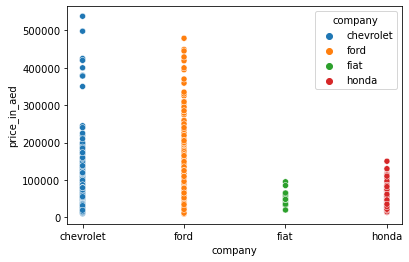

In [10]:
sns.scatterplot(data=dados, x="company", y=preco, hue= dados['company'])

In [11]:
companhiaPreco = dados.groupby(dados['company'])['price_in_aed'].describe()
companhiaPreco

,count,mean,std,min,25%,50%,75%,max
company,,,,,,,,
chevrolet,237.0,92546.991561,86858.518345,9900.0,35000.0,68000.0,118000.0,538000.0
fiat,14.0,51657.142857,20942.878881,19500.0,35750.0,48000.0,63575.0,95000.0
ford,463.0,100827.455724,90226.625980,9000.0,36500.0,68000.0,135000.0,479000.0
honda,126.0,53822.031746,27634.000426,13500.0,30000.0,49999.5,71975.0,149999.0


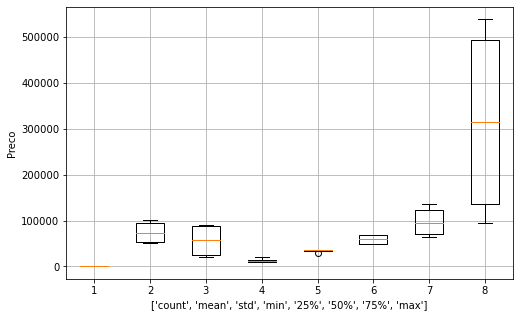

In [16]:
plt.figure(figsize=(8,5))
plt.boxplot(companhiaPreco)
plt.xlabel(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
plt.ylabel('Preco')
plt.grid()
plt.show()

----
### Preço x Condição

In [17]:
corpoPreco = dados.groupby(dados['body_condition'])['price_in_aed'].describe()
corpoPreco

,count,mean,std,min,25%,50%,75%,max
body_condition,,,,,,,,
"A bit of wear & tear, all repaired",18.0,46011.111111,26156.472349,9000.0,33500.0,41350.0,59500.0,120000.0
"No accidents, very few faults",26.0,60795.961538,45334.277363,11000.0,27000.0,62000.0,79000.0,225000.0
Perfect inside and out,796.0,92603.806533,85108.931909,9900.0,35000.0,63900.0,117250.0,538000.0


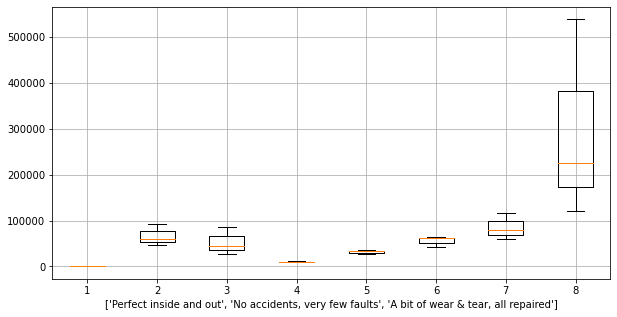

In [19]:
bodytype = []
for tipo in dados['body_condition']:
    if tipo not in bodytype:
        bodytype.append(tipo)
len(bodytype)

plt.figure(figsize=(10,5))
plt.boxplot(corpoPreco)
plt.xlabel(bodytype)
plt.grid()
plt.show()

----
### Preço x Tipo

In [20]:
dados.groupby(dados['body_type'])['price_in_aed'].describe()

,count,mean,std,min,25%,50%,75%,max
body_type,,,,,,,,
Coupe,86.0,92339.523256,71804.318915,23000.0,52375.0,68500.0,114750.0,379900.0
Crossover,10.0,60840.000000,37463.617907,27500.0,32500.0,59450.0,65375.0,155000.0
Hard Top Convertible,16.0,217987.437500,158677.589570,19500.0,100500.0,185000.0,302750.0,538000.0
Hatchback,48.0,34131.229167,17710.371639,11800.0,19375.0,32700.0,44900.0,85000.0
Pick Up Truck,124.0,159580.274194,102246.972856,28000.0,84425.0,140995.0,205000.0,479000.0
SUV,331.0,84989.084592,73065.925996,11000.0,35000.0,58000.0,103300.0,359000.0
Sedan,149.0,39979.778523,20852.625265,9000.0,24500.0,35000.0,52000.0,128900.0
Soft Top Convertible,18.0,107888.888889,72768.479673,13000.0,63375.0,81250.0,123750.0,293000.0
Sports Car,58.0,114267.241379,83397.810960,39000.0,72750.0,89500.0,118750.0,425000.0


----
### Preço x Tipo de Transmissão

In [21]:
dados.groupby(dados['transmission_type'])['price_in_aed'].describe()

,count,mean,std,min,25%,50%,75%,max
transmission_type,,,,,,,,
Automatic Transmission,804.0,90956.747512,84430.504442,9000.0,35000.0,62000.0,114992.5,538000.0
Manual Transmission,36.0,83119.444444,67057.603466,19500.0,35750.0,63000.0,95750.0,350000.0


----
### Preço x Cavalos

In [22]:
dados.groupby(dados['horsepower'])['price_in_aed'].describe()

,count,mean,std,min,25%,50%,75%,max
horsepower,,,,,,,,
150 - 200 HP,145.0,42952.993103,22470.943542,11800.0,26900.0,37000.0,55000.0,128900.0
200 - 300 HP,233.0,66926.326180,59112.982774,11000.0,33000.0,48500.0,75000.0,350000.0
300 - 400 HP,235.0,97856.702128,66778.241704,14000.0,50750.0,80000.0,125000.0,325000.0
400 - 500 HP,144.0,168814.486111,111041.208954,21500.0,92250.0,134000.0,210000.0,538000.0
500 - 600 HP,24.0,196374.958333,130143.990115,9000.0,98000.0,166000.0,256750.0,429000.0
Less than 150 HP,59.0,38659.271186,20035.596913,9900.0,23150.0,32900.0,48999.5,85000.0


----
### Preço x Ano

In [23]:
dados.groupby(dados['year'])['price_in_aed'].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
1960.0,1.0,350000.000000,NaN,350000.0,350000.0,350000.0,350000.0,350000.0
1965.0,2.0,236500.000000,79903.066274,180000.0,208250.0,236500.0,264750.0,293000.0
1971.0,2.0,130000.000000,7071.067812,125000.0,127500.0,130000.0,132500.0,135000.0
1973.0,1.0,160000.000000,NaN,160000.0,160000.0,160000.0,160000.0,160000.0
1975.0,1.0,110000.000000,NaN,110000.0,110000.0,110000.0,110000.0,110000.0
1979.0,1.0,95000.000000,NaN,95000.0,95000.0,95000.0,95000.0,95000.0
1990.0,1.0,38000.000000,NaN,38000.0,38000.0,38000.0,38000.0,38000.0
2001.0,1.0,57800.000000,NaN,57800.0,57800.0,57800.0,57800.0,57800.0
2002.0,1.0,19500.000000,NaN,19500.0,19500.0,19500.0,19500.0,19500.0


----
### Preço x Km

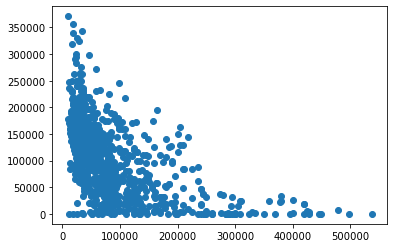

In [24]:
# sns.scatterplot(data=dados, x="company", y=preco, hue= dados['company'])

plt.scatter(dados['price_in_aed'],dados['kilometers'])
plt.show()

In [25]:
#anoQuilometragem = dados.kilometers.corr(dados.year)

precoQuilometragem = preco.corr(dados.kilometers)
print(precoQuilometragem)


-0.5516178757132725


----
# Analise de dados

In [94]:
dados = pd.read_excel('carros.xlsx', dtype={'body_type':'category', 'body_condition':'category', 'company': 'category', 'transmission_type': 'category', 'horsepower': 'category','fuel_type': 'category', 'mechanical_condition': 'category', 'company': 'category' })

# REMOVENDO COLUNAS QUE FORAM JULGADAS DESNECESSARIAS
dados.drop(["seller_type", "no_of_cylinders", "regional_specs", "steering_side", "color", "emirate","motors_trim","model"], axis=1, inplace=True)


# FILTRANDO AS MARCAS QUE SERAM UTILIZADAS
# marcas = ['nissan', 'audi', 'mercedes-benz', 'lamborghini', 'maserati', 'bmw', 'bentley','ferrari']
marcas = ['ford', 'chevrolet', 'fiat', 'honda'] # Já que as outras marcas deixavam nossos preços com uma variedade gigantesca, optamos por mudar para marcas com preços mais padronizados
dados = dados.loc[dados.company.isin(marcas),:]


# DEFININDO VARIAVEIS
preco = dados['price_in_aed'].apply(lambda x: float(x.replace(".","").replace(",","")))

dados['price_in_aed'] = preco
marca = dados['company']
condicao = dados['body_condition']
tipo = dados['body_type']
transmissao = dados['transmission_type']
cavalos = dados['horsepower']
ano = dados['year']
km = dados['kilometers']
combustivel = dados['fuel_type']
mecanico = dados['mechanical_condition']


# Por conta de alguns casos particulares, usamos esse filtro para padronizar os valores
dados = dados.loc[dados['kilometers']<400000,:] # tirar os casos de carros com quilometragens absurdas
dados = dados.loc[dados['price_in_aed']<1099000,:] # tinha 1 carro que era muito mais caro que todos os outros
dados = dados.loc[dados['horsepower']!='Unknown',:] # alguns carros tinham o horsepowe indefinido, aqui estamos filtrando eles
dados = dados.loc[dados['year'].isnull()==False,:] # Tirando valores nulos da coluna ano


# Pouco Exemplo
dados = dados.loc[dados['body_type']!='Utility Truck']
dados = dados.loc[dados['body_type']!='Van']
dados = dados.loc[dados['body_type']!='Wagon']
dados = dados.loc[dados['body_type']!='Other']

dados = dados.loc[dados['body_condition']!=('Normal wear & tear, a few issues'),:]
dados = dados.loc[dados['horsepower']!=('600 - 700 HP'),:]
dados = dados.loc[dados['horsepower']!=('900+ HP'),:]
dados = dados.loc[dados['horsepower']!=('700 - 800 HP'),:]

dados = dados.loc[dados['fuel_type']!=('Electric'),:]
dados = dados.loc[dados['fuel_type']!=('Diesel'),:]
dados = dados.loc[dados['fuel_type']!=('Hybrid'),:]


# Ja que o combustivel que estamos considerando é só Gasolina, tiramos a coluna "fuel_type"
dados.drop(['fuel_type'], axis=1, inplace=True)


# Transformando as variaveis em valores numericos
dados['Corpo'] = dados['body_type'].cat.codes
dados['Condicao Corpo'] = dados['body_condition'].cat.codes
dados['Condicao Mecanica'] = dados['mechanical_condition'].cat.codes
dados['Transmissao'] = dados['transmission_type'].cat.codes
dados['Cavalos'] = dados['horsepower'].cat.codes
dados['Marcas'] = dados['company'].cat.codes

#colocando as faixas de preço novamente
faixas = np.linspace(5000,540000,20)

dados['precoFaixa'] = pd.cut(preco, bins=faixas)


KeyboardInterrupt: 

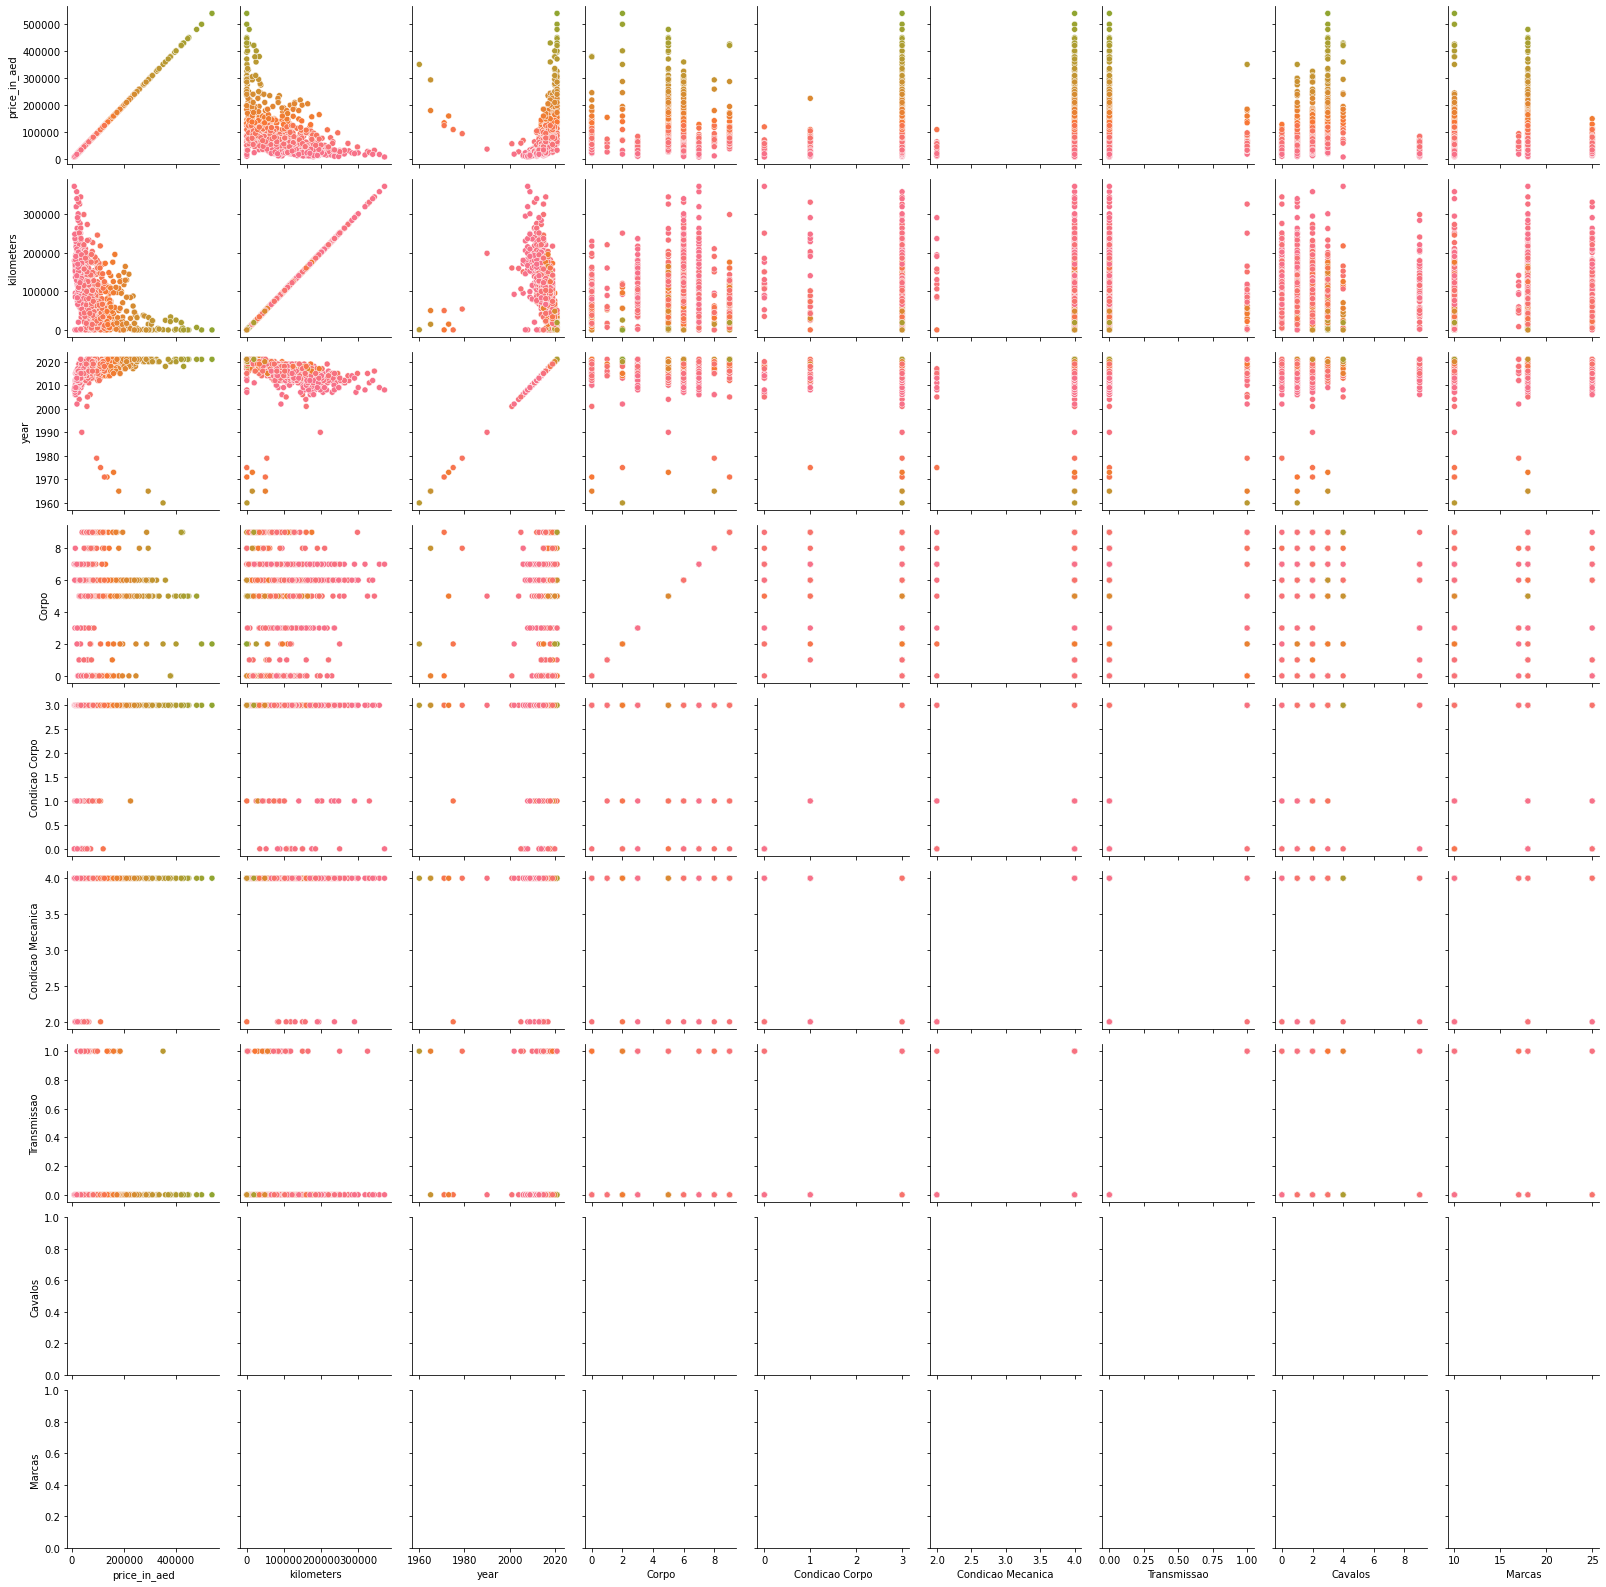

In [61]:
x = sns.PairGrid(dados, hue='precoFaixa', height=2.5)
x.map(sns.scatterplot)
# Cada cor de bolinhas nesse grafico é uma faixa de preço

In [85]:
X=dados[['Marcas','Condicao Corpo','Corpo','Transmissao','Cavalos','year','kilometers','Condicao Mecanica']]  # Features
y=dados['price_in_aed']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test


#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [86]:
feature_imp = pd.Series(clf.feature_importances_,index=iris.feature_names).sort_values(ascending=False)
feature_imp

kilometers           0.418012
year                 0.209067
Corpo                0.133015
Cavalos              0.123025
Marcas               0.074101
Condicao Corpo       0.022645
Transmissao          0.014679
Condicao Mecanica    0.005456
dtype: float64

No handles with labels found to put in legend.


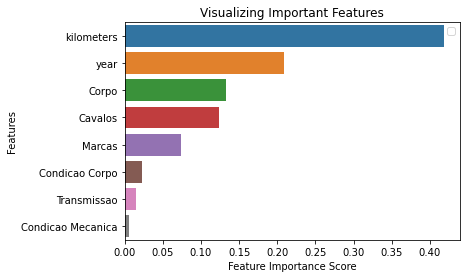

In [87]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

# Predição por Regressão Logistica Simples

In [78]:
X=dados[['Marcas','Condicao Corpo','Corpo','Transmissao','Cavalos','year','kilometers','Condicao Mecanica']]  # Features
y=dados['price_in_aed']  # Labels

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [79]:
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

C:\Users\55119\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

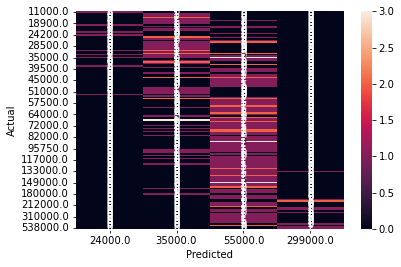

In [46]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [92]:
print('Probabilidade de acertar exatamente o preço do carro: ',metrics.accuracy_score(y_test, y_pred))
plt.show()

Probabilidade de acertar exatamente o preço do carro:  0.05952380952380952


Como essa probabilidade é muito baixa, deduzimos que seja mais apropriado a tentativa de acertar o valor do carro dentro de um intervalo de preços. Mudando nosso approch e predizer um range, por exemplo 0-40k, 41-69k, 70-100k, e assim por diante.